# Estimating Lithium-ion Battery Health

### Introduction to Lithium-based batteries, their cycles characteristics and aging

Lithium-ion (or Li-ion) batteries are rechargeable batteries used for a variety of electronic devices, which range from eletric vehicles, smartphones, and even satellites.

However, despite their wide adoption, research isn't mature enough to avoid problems with battery health and safety, and given the ubiquity of consumer electronics using the technology, this has led to some poor outcomes that range from poor user-experience to public safety concerns (see, for example, the Samsung Galaxy Note 7 explosions from 2016).

### Dataset

In this example of **predictive maintenance**, we propose a data-driven method to estimate the health of a battery using the [Li-ion battery dataset](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/) released by NASA ([csv](../../data/battery5_data.zip)).

This dataset includes information on Li-ion batteries over several charge and discharge cycles at room temperature. Charging was at a constant current (CC) at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. Discharge was at a constant current (CC) level of 2A until the battery voltage fell to 2.7V.

You can download the Jupyter notebook of this study <a href="battery.ipynb">here</a>.

The dataset includes the following:
<ul class="ul_content">
<li><b>Voltage_measured</b>: Battery's terminal voltage (Volts) for charging and discharging cycles</li>
<li><b>Current_measured</b>: Battery's output current (Amps) for charging and discharging cycles</li>
<li><b>Temperature_measured</b>: Battery temperature (degree Celsius)</li>
<li><b>Current_charge</b>: Current measured at charger for charging cycles and at load for discharging cycles (Amps)</li>
<li><b>Voltage_charge</b>: Voltage measured at charger for charging cycles and at load for discharging ones (Volts)</li>
<li><b>Start_time</b>: Starting time of the cycle</li>
<li><b>Time</b>: Time in seconds after the starting time for the cycle (seconds)</li>
<li><b>Capacity</b>: Battery capacity (Ahr) for discharging until 2.7V. Battery capacity is the product of the current drawn from the battery (while the battery is able to supply the load) until its voltage drops lower than a certain value for each cell.</li>
</ul>

### Initialization

This example uses the following version of VerticaPy:

In [1]:
import verticapy as vp
vp.__version__

'0.9.0'

Connect to Vertica. This example uses an existing connection called "VerticaDSN." For details on how to create a connection, use see the <a href="../../connection.php">connection tutorial</a>.

In [2]:
vp.connect("VerticaDSN")

Before we import the data, we'll drop any existing schemas of the same name.

In [13]:
vp.drop("battery_data", method="schema")
vp.create_schema("battery_data", True)

True

Since our data is in a .csv file, we'll injest it with <a href="../../documentation_last/utilities/read_csv/">read_csv()</a>.

In [15]:
battery5 = vp.read_csv("data/battery5_data.csv")

## Understanding the Data

Let's examine our data. Here, we use vDataFrame.<a href="../../documentation_last/vdataframe/main-methods/head/">head()</a> to retrieve the first five rows of the dataset.

Voltage_measured        Current_measured    Temperature_measured   \\
1    0.00336524422388181    -0.00149573390003958         23.369433909575   \\
2      0.236356184152679    -0.00348442627618414        23.3720475048121   \\
3       2.45567932466456       -2.01259011577148         38.418742770556   \\
4       2.47131476433413       -2.01438891947297        38.0765742576909   \\
5       2.47244830185273       -2.00928251876441        38.4230398541122   \\
     Current_charge    Voltage_charge        Time         type   \\
1               0.0             0.003       2.547       charge   \\
2               0.0             0.003         0.0       charge   \\
3           -1.9982             1.685    3250.766    discharge   \\
4           -1.9982             1.695    3270.922    discharge   \\
5           -1.9982             1.684    3290.234    discharge   \\
                     start_time    ambient_temp            Capacity  
1    2008-05-28 11:09:42.000045              24                None  
2    2008-05-28 11:09:42.000045              24                None  
3    2008-04-05 22:46:35.000484              24     1.8027776247196  
4    2008-04-20 15:37:05.000280              24    1.81396938871035  
5    2008-04-04 09:57:19.000765              24    1.82461955268645  
Rows: 1-5 | Columns: 10
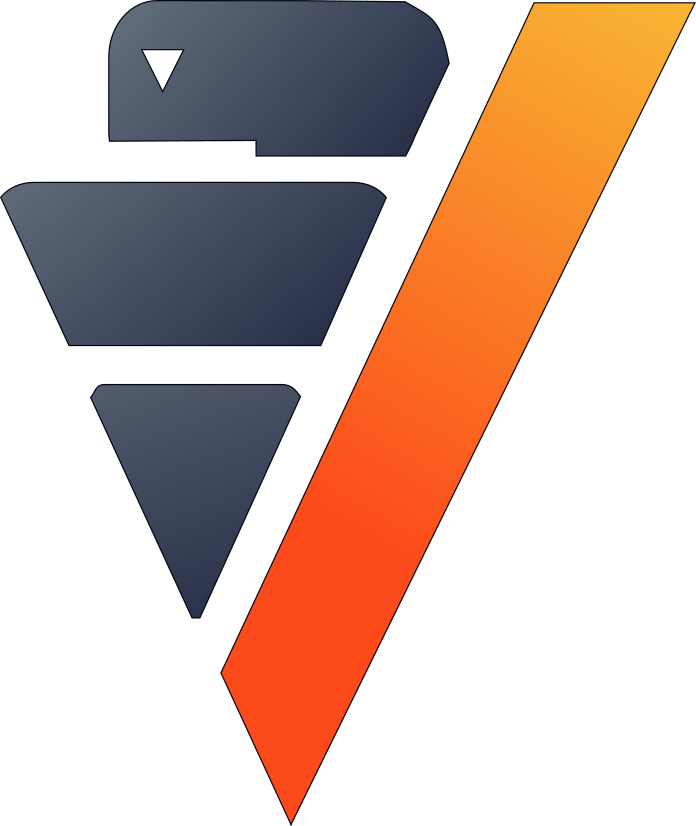

In [16]:
display(battery5.head(5))

Let's perform a few aggregations with vDataFrame.<a href="../../documentation_last/vdataframe/main-methods/describe/">describe()</a> to get a high-level overview of the dataset.

count                 mean                  std                    min   \\
"Voltage_measured"          591458     4.10394503838216    0.213468670467274    0.00336524422388181   \\
"Current_measured"          591458    0.369404334640848    0.907557734956734       -4.4796596195982   \\
"Temperature_measured"      591458     26.3697006309627     2.77242440009329       23.2148017857281   \\
"Current_charge"            591458    0.634475697682678    0.737028608855502                 -4.468   \\
"Voltage_charge"            591458     4.02493041771349     1.20882522698251                    0.0   \\
"Time"                      591458     4763.85693356587     3147.85902580761                    0.0   \\
"ambient_temp"              591458                 24.0                  0.0                   24.0   \\
"Capacity"                   50285      1.5603447176546    0.182379527870387       1.28745252213794   \\
                                    approx_25%           approx_50%          approx_75%   \\
"Voltage_measured"            4.09215314651007     4.20514178323903    4.20590319772839   \\
"Current_measured"          0.0429636729663627    0.173576699239392    1.21853946684833   \\
"Temperature_measured"        24.4903730883168     25.4763331289557    27.3467360778907   \\
"Current_charge"                         0.057                0.261               1.498   \\
"Voltage_charge"                          4.24                4.305               4.656   \\
"Time"                        1927.86585492228     4492.69086367347     7535.1736750753   \\
"ambient_temp"                            24.0                 24.0                24.0   \\
"Capacity"                    1.38622876779783     1.53823659894256    1.74687061798379   \\
                                         max  
"Voltage_measured"          8.39314118056463  
"Current_measured"          1.53130142697453  
"Temperature_measured"      41.4502319190386  
"Current_charge"                      1.9984  
"Voltage_charge"                       5.002  
"Time"                             10807.328  
"ambient_temp"                          24.0  
"Capacity"                  1.85648742081816  
Rows: 1-8 | Columns: 9
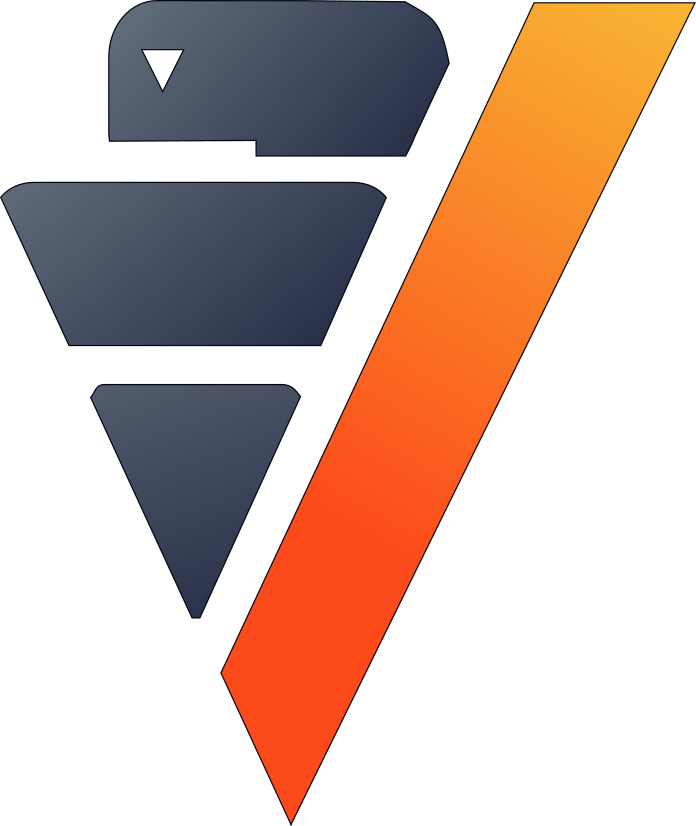

In [17]:
battery5.describe()

To get a better idea of the changes between each cycle, we look at an aggregation at their start time, duration, and voltage at the beginning and the end of each cycle.

value  
name                     "start_time"  
dtype                       timestamp  
count                          591458  
min        2008-04-02 13:08:17.000920  
max        2008-05-28 11:09:42.000045  
Rows: 1-5 | Columns: 2
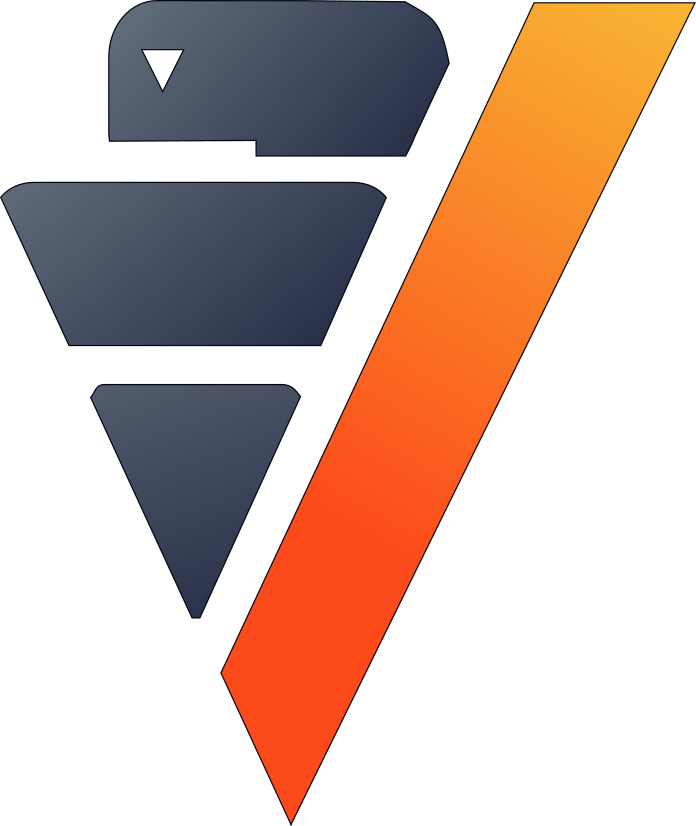

In [18]:
battery5['start_time'].describe()

To see how the voltage changes during the cycle, we extract the initial and final voltage measurements for each cycle.

start_time         type    first_voltage_measured   \\
1      2008-04-02 13:08:17.000920       charge            3.873017221301   \\
2      2008-04-02 15:25:41.000593    discharge          4.19149180750529   \\
3      2008-04-02 16:37:51.000984       charge          3.32505465684485   \\
4      2008-04-02 19:43:48.000405    discharge          4.18977321384661   \\
5      2008-04-02 20:55:40.000811       charge          3.35260365999878   \\
6      2008-04-03 00:01:06.000687    discharge           4.1881867359913   \\
7      2008-04-03 01:12:38.000670       charge          3.37879897651295   \\
8      2008-04-03 04:16:37.000375    discharge          4.18846111885557   \\
9      2008-04-03 05:27:49.000125       charge          3.37287091743927   \\
10     2008-04-03 08:33:25.000702    discharge          4.18829852476105   \\
11     2008-04-03 09:44:35.000078       charge          3.36677489940929   \\
12     2008-04-03 12:55:10.000686    discharge           4.1888158079486   \\
13     2008-04-03 14:06:43.000234       charge          3.36103565660438   \\
14     2008-04-03 17:17:16.000015    discharge          4.18839163793879   \\
15     2008-04-03 18:28:47.000125       charge          3.35394264777825   \\
16     2008-04-03 21:28:14.000718    discharge          4.18892789151196   \\
17     2008-04-03 22:38:27.000452       charge          3.38652722446754   \\
18     2008-04-04 01:38:15.000217    discharge          4.18902925088212   \\
19     2008-04-04 02:48:06.000155       charge           3.3775954668098   \\
20     2008-04-04 05:48:08.000609    discharge          4.18922342707642   \\
21     2008-04-04 06:58:00.000296       charge          3.37165307123999   \\
22     2008-04-04 09:57:19.000765    discharge          4.18891605591124   \\
23     2008-04-04 11:06:50.000375       charge          3.36116950771313   \\
24     2008-04-04 15:05:59.000905       charge          3.64784226605724   \\
25     2008-04-04 17:56:27.000609    discharge          4.18987624726632   \\
26     2008-04-04 19:05:19.000234       charge          3.39188020778012   \\
27     2008-04-04 22:01:54.000670    discharge           4.1892867947688   \\
28     2008-04-04 23:10:25.000420       charge            3.381025252311   \\
29     2008-04-05 02:20:26.000702    discharge          4.18883776589273   \\
30     2008-04-05 03:28:57.000234       charge          3.37527210719229   \\
31     2008-04-05 06:25:01.000890    discharge          4.18911030176852   \\
32     2008-04-05 07:33:12.000734       charge          3.41078105386178   \\
33     2008-04-05 10:30:32.000311    discharge          4.18921207304098   \\
34     2008-04-05 11:38:22.000140       charge          3.40508272130911   \\
35     2008-04-05 14:34:41.000468    discharge          4.18889996942811   \\
36     2008-04-05 15:42:11.000531       charge          3.39671667970665   \\
37     2008-04-05 18:39:25.000217    discharge          4.18877979985679   \\
38     2008-04-05 19:46:36.000125       charge          3.38694300850099   \\
39     2008-04-05 22:46:35.000484    discharge          4.18927259151622   \\
40     2008-04-18 17:34:22.000890       charge          3.57954991793827   \\
41     2008-04-18 21:10:19.000795    discharge          4.18761406056344   \\
42     2008-04-18 22:53:58.000343       charge          3.38908568014577   \\
43            2008-04-19 02:29:09    discharge           4.1876287811084   \\
44     2008-04-19 04:12:06.000343       charge          3.38074306476638   \\
45     2008-04-19 07:47:15.000702    discharge          4.18744722631293   \\
46     2008-04-19 09:29:52.000703       charge          3.41207028563506   \\
47     2008-04-19 13:01:42.000561    discharge          4.18734402638716   \\
48     2008-04-19 14:43:41.000265       charge          3.43689487357187   \\
49     2008-04-19 18:27:29.000827    discharge          4.18743818763633   \\
50     2008-04-19 20:09:47.000750       charge          3.43154231233248   \\
51     2008-04-19 23:41:55.000686    discharg
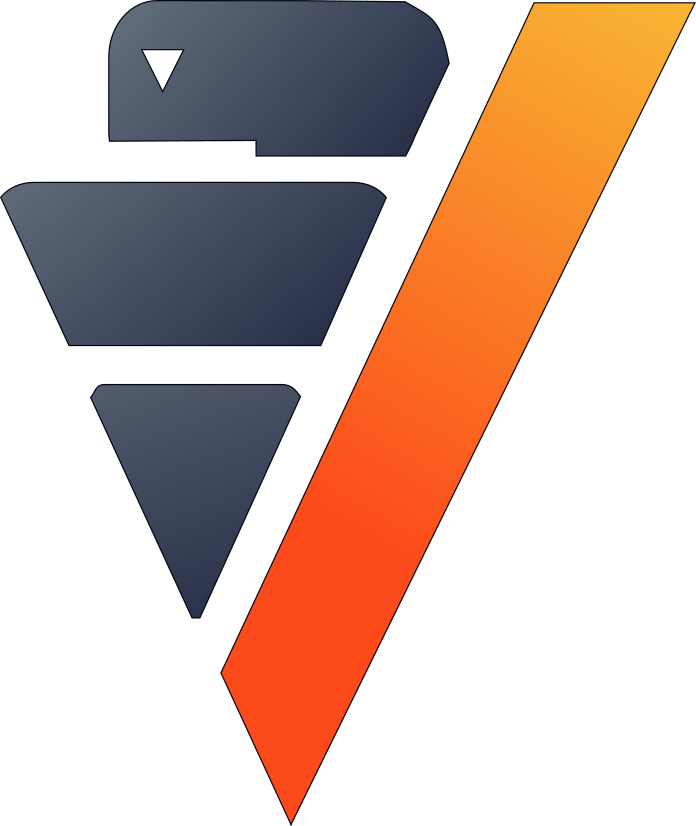

In [19]:
battery5.analytic(func="first_value",
                  columns="Voltage_measured",
                  by="start_time",
                  order_by={"Time":"asc"},
                  name="first_voltage_measured")

battery5.analytic(func="first_value",
                  columns="Voltage_measured",
                  by="start_time",
                  order_by={"Time":"desc"},
                  name="last_voltage_measured")

cycling_info = battery5.groupby(columns = ['start_time',
                                           'type',
                                           'first_voltage_measured',
                                           'last_voltage_measured'], 
                                expr = ["COUNT(*) AS nr_of_measurements",
                                        "MAX(Time) AS cycle_duration"]).sort('start_time')
cycling_info['cycle_id'] = "ROW_NUMBER() OVER(ORDER BY start_time)"
cycling_info

We can see from the "duration" column that charging seems to take a longer time than discharging. Let's visualize this trend with an animated graph.

In [20]:
import warnings
warnings.filterwarnings('ignore')
cycling_info.animated(ts="start_time",
                      columns= ["type","cycle_duration"], 
                      by="type", 
                      kind="bar",)

The animated graph below shows how the cycles change throughout time. Another way we can verify that charging cycles are longer than discharging cycles is by looking at the average duration of each type of cycle.

<AxesSubplot:xlabel='AVG("cycle_duration")', ylabel='"type"'>

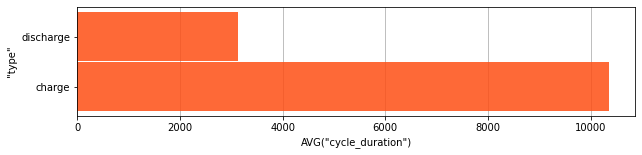

In [21]:
cycling_info.bar(["type"], 
                 method = "avg", 
                 of = "cycle_duration")

In general, charging cycles are longer than discharging cycles. Let's examine how voltage changes between cycles and their transitions.

type    min_first_voltage    avg_first_voltage    max_first_voltage   \\
1       charge    0.236356184152679     3.62261106314154     8.39314118056463   \\
2    discharge     4.18453480301131     4.19597100862757     4.22292005793579   \\
     min_last_voltage    avg_last_voltage    max_last_voltage  
1    4.18725399564513     4.1986688743734    4.21343968400049  
2    3.20506891560499     3.4713048542903     3.6211910328537  
Rows: 1-2 | Columns: 7
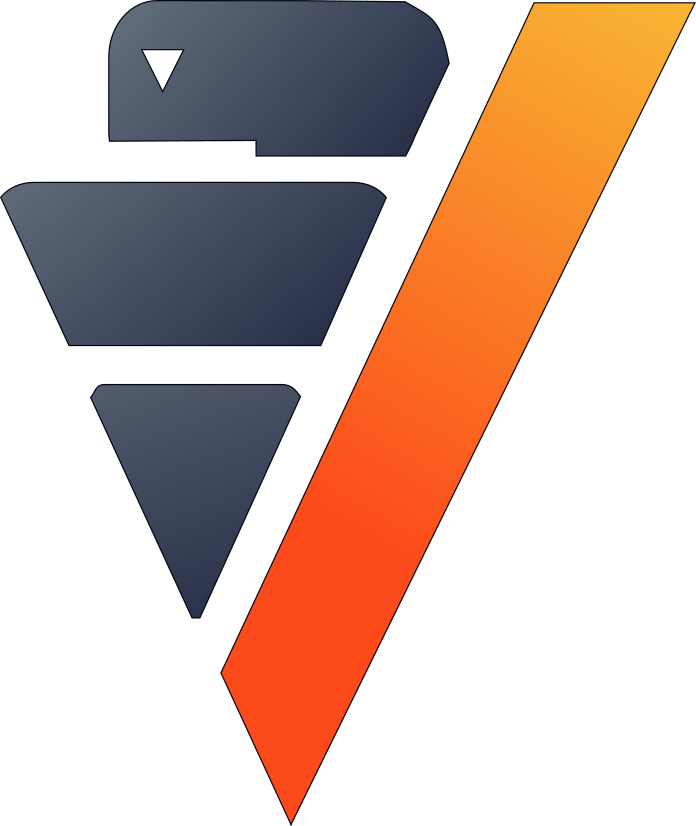

In [22]:
cycling_info.groupby('type',['MIN(first_voltage_measured) AS min_first_voltage',
                             'AVG(first_voltage_measured) AS avg_first_voltage',
                             'MAX(first_voltage_measured) AS max_first_voltage',
                             'MIN(last_voltage_measured)  AS min_last_voltage',
                             'AVG(last_voltage_measured)  AS avg_last_voltage',
                             'MAX(last_voltage_measured)  AS max_last_voltage'])

From this table, it looks like batteries are charged until they are almost full (4.2V) and discharging doesn't begin until they are fully charged.

End-of-life (EOL) criteria for batteries is usually defined as when the battery capacity is lower than 70%-80% of its rated capacity. Since the rated capacity by the manufacturer for this battery is 2Ah, this battery is considered EOL when its capacity reaches 2Ah x 70% = 1.4Ah.

Let's plot the capacity curve of the battery with its smoothed version and observe when it reaches the degradation criteria. 

<Figure size 432x288 with 0 Axes>

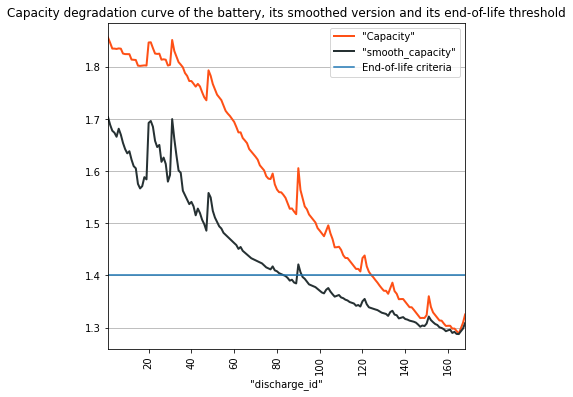

In [23]:
# Visualize the capacity degradation curve along with its smoothed version
discharging_data = battery5[battery5['type'] == 'discharge']
d_cap = discharging_data[['start_time', 'Capacity']].groupby(['start_time', 'Capacity'])
d_cap["discharge_id"] = "ROW_NUMBER() OVER(ORDER BY start_time, Capacity)"
d_cap.rolling(func = 'mean',
              columns = 'capacity',
              window = (-100, -1),
              name = 'smooth_capacity')


import matplotlib.pyplot as plt
from matplotlib.pyplot import axhline

fig = plt.figure()
ax = d_cap.plot(ts = 'discharge_id', columns = ['Capacity', 'smooth_capacity'])
ax.axhline(y=1.4, label='End-of-life criteria')
ax.set_title('Capacity degradation curve of the battery, its smoothed version and its end-of-life threshold')
ax.legend() 
plt.show()

The sudden increases in battery capacity come from the self-charging property of Li-ion batteries. The smoothed graph makes the downward trend in the battery's capacity very clear.

An important observation here is that the battery meets the EOL criteria around the 125th cycle.

## Goal and Problem Modeling

Understanding battery health is important, but at the time of writing, there's no direct way to measure it. In our case, we'll create a degredation model to find the relationship between a battery's overall health and the other properties in the dataset, which includes charge and discharge cycle duration, average voltage and current, etc.

One possible definition of the battery's overall health ("state of health" or "SoH") is the following:

Let 
 
be the rated capacity of the battery when its new (2Ah in our case),
   and  be the actual capacity of the battery at specific time. The
state of health of the battery is defined as:
    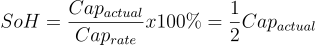


In order to find this relationship, we'll clean and prepare our data by adding some extra features. These extra features will help us understand how the battery behaves during and between each cycle and pinpoint what might be the primary causes for battery degredation.

## Data Preparation

### Outlier detection

Let's start by finding and removing the global outliers from our dataset.

7803 elements were filtered.


Voltage_measured         Current_measured    Temperature_measured   \\
1        4.191077562802     -0.00289244415825233        24.5070404981243   \\
2      4.19145297803654     -0.00185593256166973        24.5143627247609   \\
3      4.19138815949231     -0.00035058934384185        24.5186725989278   \\
4      4.19129900116523    -0.000942382137392054        24.5324979494391   \\
5      4.19082169589584     -0.00339135418490738        24.5393972895358   \\
6      4.19117480835044     -0.00329235713967974        24.5484975198514   \\
7      4.19085954561673     -0.00187706505598586        24.5560428090257   \\
8      4.19083893634414     -0.00200329339068276        24.5675754256341   \\
9      4.19098209980588     -0.00267139684978806          24.57598626898   \\
10     4.19084885245013     -0.00131944726054101        24.5931622876176   \\
11     4.19103086559357     -0.00519602031106074        24.5965952874239   \\
12     4.19088542845538      0.00166965239240655        24.6067700461602   \\
13     4.19037884805604    -0.000585054454874253        24.6067947045446   \\
14     4.19038472665687     -0.00233421183923724        24.6235176792457   \\
15     4.19039339764219    -0.000672934960173503        24.6455055765759   \\
16     4.18992934989144    -0.000980390869617877        24.6514220273314   \\
17     4.18950409720076     -0.00118803975546709        24.6498614594621   \\
18     4.18937661468013     -0.00135290178219755        24.6758638366935   \\
19     4.18866542676157     -0.00175735415797255        24.6839175921507   \\
20     4.18799981651757      -0.0010559213440312        24.6985048214946   \\
21     4.18711484139018     0.000633490859740153          24.72235444727   \\
22     4.18557368432219     -0.00427117174588695        24.7396655257138   \\
23     4.18354651785376      -0.0028237916834498        24.7485471119508   \\
24     4.18072221326857    -0.000370081430176359        24.7577774172585   \\
25     4.17596639053681     -0.00278431886048148         24.768309354088   \\
26     4.16748106370293     -0.00319665758847235        24.7299187674368   \\
27     4.13560691014186    -0.000347027949984981        24.4645469045721   \\
28      4.2056012283435       0.0111602216542072        24.1820599066707   \\
29     4.20685291152986        0.024036235247763        24.1720437644251   \\
30     4.20771241601534       0.0325929302871062        24.1877671946696   \\
31     4.20740341858764       0.0342967714484646        24.1801854196917   \\
32     4.20734197683408        0.034537123609793        24.1833955872426   \\
33     4.20746955475074       0.0309711450494699        24.1834450856869   \\
34     4.20729355146729       0.0298876170956639        24.1855313143001   \\
35     4.20750887264527        0.031138735257609        24.1903490936464   \\
36     4.20728056530391       0.0334838962294185        24.1783019359187   \\
37     4.20698446872691       0.0320836679055509        24.1759824543016   \\
38     4.20724251314163        0.031169216223246        24.1806191674626   \\
39     4.20709369371337       0.0336632872514224        24.1723066302381   \\
40     4.20719024894999       0.0311218760839418        24.1719975661511   \\
41     4.20704595249473        0.032811414430697        24.1709896911355   \\
42     4.20688651932817       0.0322522051940632        24.1670618808059   \\
43     4.20697163051597       0.0332390898132783        24.1691396191406   \\
44     4.20689004904342       0.0306191615299643        24.1820567708101   \\
45     4.20694806595952       0.0352225293605038        24.1760758094498   \\
46     4.20687946516883       0.0344207457923223        24.1804828953539   \\
47     4.20699969325079        0.034253721675264        24.1853530656035   \\
48     4.20675653903863       0.0354057522318628        24.1837467486538   \\
49     4.20704426915562       0.0330528526099921        24.1822902313404   \\
50     4.20696909556644       0.0338365092366179        24.1800061071641   \\
51     4.20654085193066      
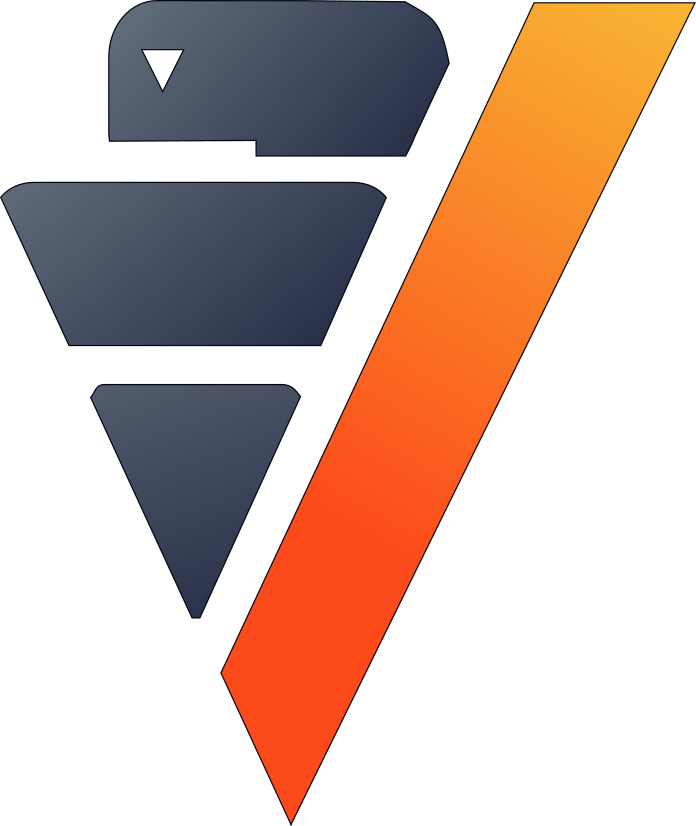

In [24]:
battery5.outliers(columns = ["Voltage_measured","Current_measured","Temperature_measured","Capacity"],
                  name = "global_outlier",
                  threshold = 4.0)
battery5.filter("global_outlier = 0").drop('global_outlier')

## Feature engineering

Since measurements like voltage and temperature tend to differ within the different cycles, we'll create some features that can describe those cycles.

<AxesSubplot:xlabel='"Time"', ylabel='"Voltage_measured"'>

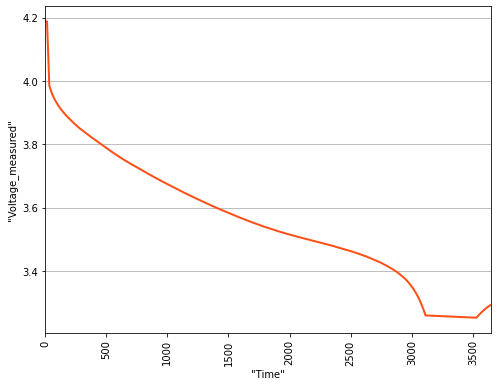

In [25]:
sample_cycle = battery5[battery5['Capacity'] == '1.83514614292266']
sample_cycle["Voltage_measured"].plot(ts = "Time")

<AxesSubplot:xlabel='"Time"', ylabel='"Temperature_measured"'>

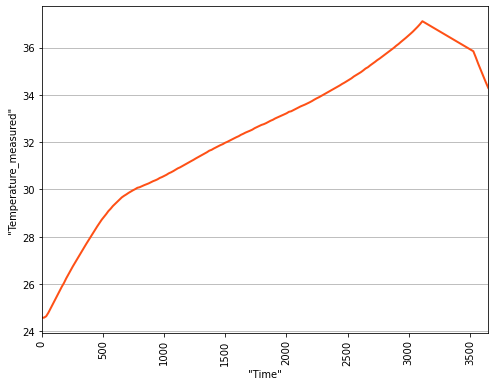

In [26]:
sample_cycle["Temperature_measured"].plot(ts = "Time")

We'll define new features that describe the minimum and maximum temperature during one cycle; the minimal voltage; and the time needed to reach minimum voltage and maximum temperature.

In [27]:
# filter for discharge cycles
discharging_data = battery5[battery5['type'] == 'discharge']


# define new features
discharge_cycle_metrics = discharging_data.groupby(columns = ['start_time'], 
                                                   expr = ['MIN(Temperature_measured) AS min_temp',
                                                           'MAX(Temperature_measured) AS max_temp',
                                                           'MIN(Voltage_measured) AS min_volt']).join(
                                                           discharging_data, 
                                                           how = "left",
                                                           on = {"min_volt":"voltage_measured"},
                                                           expr1 = ["*"],
                                                           expr2 = ["Time AS time_to_reach_minvolt"]).join(
                                                           discharging_data, 
                                                           how = "left",
                                                           on = {"max_temp":"temperature_measured"},
                                                           expr1 = ["*"],
                                                           expr2 = ["Time AS time_to_reach_maxtemp"])

# calculate values of SOH
discharging_data = discharging_data.groupby(['start_time','Capacity'])
discharging_data['SOH'] = discharging_data['Capacity'] * 0.5

start_time               min_temp              max_temp   \\
1      2008-04-02 15:25:41.000593      0.323719818945165     0.734249807626277   \\
2      2008-04-02 19:43:48.000405      0.428584253762227     0.914351158360577   \\
3      2008-04-03 00:01:06.000687      0.442660578483156     0.795738011577447   \\
4      2008-04-03 04:16:37.000375      0.418765254851753     0.661205504813534   \\
5      2008-04-03 08:33:25.000702      0.379860520846069      0.54435119574023   \\
6      2008-04-03 12:55:10.000686      0.378615452772031     0.618246536336501   \\
7      2008-04-03 17:17:16.000015      0.396431419261175     0.673902853713857   \\
8      2008-04-03 21:28:14.000718       0.43597699765424     0.654370511378216   \\
9      2008-04-04 01:38:15.000217      0.411844366919643     0.509666695146447   \\
10     2008-04-04 05:48:08.000609      0.392346756721263      0.46136681915143   \\
11     2008-04-04 09:57:19.000765      0.354394096577351     0.389886787277656   \\
12     2008-04-04 17:56:27.000609       0.44443933699264     0.649026660804619   \\
13     2008-04-04 22:01:54.000670      0.442323086774679     0.641544023693975   \\
14     2008-04-05 02:20:26.000702      0.359258760394804     0.417315395909952   \\
15     2008-04-05 06:25:01.000890      0.363661789774252     0.357247610892989   \\
16     2008-04-05 10:30:32.000311       0.32212275666383     0.294657404834105   \\
17     2008-04-05 14:34:41.000468      0.332846583617716      0.34710768730742   \\
18     2008-04-05 18:39:25.000217      0.340158365928614     0.311033039002458   \\
19     2008-04-05 22:46:35.000484      0.332179071683428     0.324922775983912   \\
20     2008-04-18 21:10:19.000795      0.388811246836356     0.621924709762114   \\
21            2008-04-19 02:29:09      0.496042567511909     0.954918308943699   \\
22     2008-04-19 07:47:15.000702      0.393630359580302     0.674627759274884   \\
23     2008-04-19 13:01:42.000561      0.291845192023113     0.365563891951362   \\
24     2008-04-19 18:27:29.000827      0.244769471060847     0.302665925764945   \\
25     2008-04-19 23:41:55.000686      0.235989158976155     0.178712955673615   \\
26     2008-04-20 04:54:41.000734      0.210170632880145     0.125029767570445   \\
27     2008-04-20 10:16:28.000859      0.173844095301586     0.124037038749743   \\
28     2008-04-20 15:37:05.000280       0.15730581031276                   0.0   \\
29     2008-04-20 20:50:38.000920      0.168767762097435    0.0743395026185572   \\
30     2008-04-21 02:15:02.000921      0.170862890502185      0.14903299932949   \\
31     2008-04-22 15:33:49.000875       0.16503534007358     0.384704893083431   \\
32     2008-04-22 20:26:18.000920        0.2880753085512     0.483944197394596   \\
33     2008-04-23 01:18:11.000795      0.228979159082955     0.488129054060406   \\
34     2008-04-23 06:18:19.000920     0.0947362875119447     0.356324687933399   \\
35     2008-04-23 11:08:00.000312      0.102341318820024     0.314299728929359   \\
36     2008-04-23 16:06:25.000170      0.220890027835113     0.884646172331595   \\
37     2008-04-23 21:02:58.000295      0.157421332451862     0.847834319585283   \\
38     2008-04-24 01:51:33.000890     0.0873225264896192     0.753827594237671   \\
39     2008-04-24 06:50:00.000031     0.0165070808273147     0.665969339357761   \\
40     2008-04-24 11:49:24.000280     0.0654221017512719     0.944709783419898   \\
41     2008-04-24 16:45:56.000015      0.234744236740332     0.945379086211842   \\
42     2008-04-24 21:38:11.000077      0.303354011196639     0.933553785415536   \\
43     2008-04-25 12:03:44.000093      0.226623179244017      0.94534710828012   \\
44     2008-04-25 20:03:55.000920      0.178200264274937     0.940595063122483   \\
45     2008-04-26 01:04:35.000718     0.0389668488819446     0.888349688690873   \\
46     2008-04-26 05:57:35.000140    0.00623800515679308     0.951302099715039   \\
47     2008-04-26 10:58:25.000843                    0.0     0.915961223013
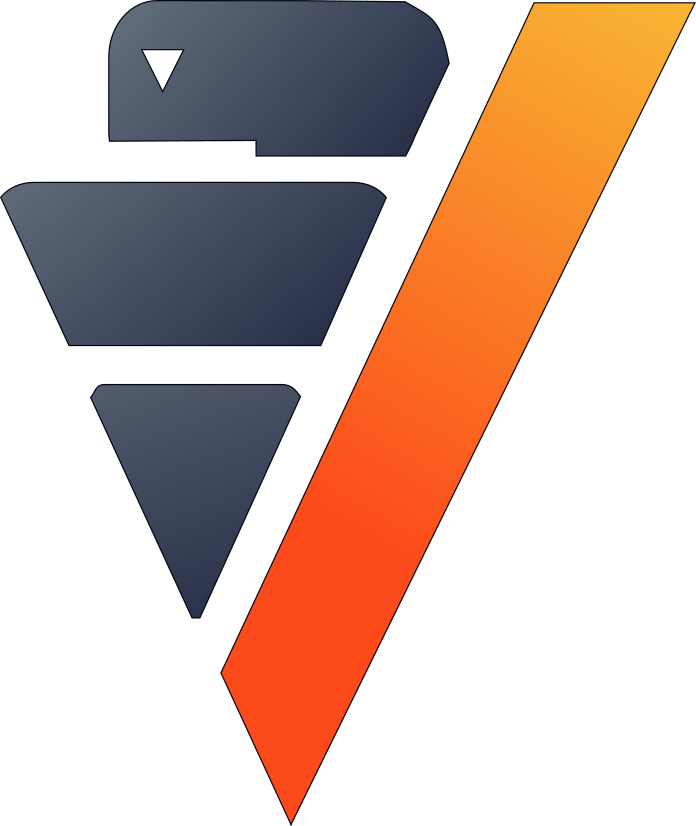

In [28]:
# define the final dataset and save it to db
final_df = discharge_cycle_metrics.join(discharging_data,
                     on_interpolate = {"start_time":"start_time"},
                     how = "left",
                     expr1 = ["*"],
                     expr2 = ["SOH AS SOH"])

# normalize the features
final_df.normalize(method = "minmax",
                   columns = ["min_temp",
                              "max_temp",
                              "min_volt",
                              "time_to_reach_minvolt",
                              "time_to_reach_maxtemp"])

# save it to db
final_df.to_db(name = "battery_data.finaldata_battery_5")

## Machine Learning

<a href="../../documentation_last/delphi/automl/">AutoML</a> tests several models and returns input scores for each. We can use this to find the best model for our dataset.

Starting AutoML




Testing Model - LinearRegression



Model: LinearRegression; Parameters: {'tol': 1e-06, 'max_iter': 100, 'solver': 'newton'}; Test_score: 0.02360579740139729; Train_score: 0.016785972410622945; Time: 0.2098848819732666;
Model: LinearRegression; Parameters: {'tol': 1e-06, 'max_iter': 100, 'solver': 'bfgs'}; Test_score: 0.02008096687524301; Train_score: 0.018674852037929093; Time: 0.4777239163716634;

Grid Search Selected Model
LinearRegression; Parameters: {'solver': 'bfgs', 'penalty': 'none', 'max_iter': 100, 'tol': 1e-06}; Test_score: 0.02008096687524301; Train_score: 0.018674852037929093; Time: 0.4777239163716634;

Testing Model - ElasticNet



Model: ElasticNet; Parameters: {'tol': 1e-06, 'max_iter': 100, 'solver': 'cgd', 'C': 1.0, 'l1_ratio': 0.5}; Test_score: 0.0946090154981508; Train_score: 0.09513062482287396; Time: 0.24749835332234701;

Grid Search Selected Model
ElasticNet; Parameters: {'solver': 'cgd', 'penalty': 'enet', 'max_iter': 100, 'l1_ratio': 0.5, 'C': 1.0, 'tol': 1e-06}; Test_score: 0.0946090154981508; Train_score: 0.09513062482287396; Time: 0.24749835332234701;

Testing Model - Ridge



Model: Ridge; Parameters: {'tol': 1e-06, 'max_iter': 100, 'C': 1.0}; Test_score: 0.017973726231011983; Train_score: 0.019579406509925495; Time: 0.2110426425933838;

Grid Search Selected Model
Ridge; Parameters: {'solver': 'newton', 'penalty': 'l2', 'max_iter': 100, 'C': 1.0, 'tol': 1e-06}; Test_score: 0.017973726231011983; Train_score: 0.019579406509925495; Time: 0.2110426425933838;

Testing Model - Lasso



Model: Lasso; Parameters: {'tol': 1e-06, 'max_iter': 100, 'solver': 'cgd', 'C': 1.0}; Test_score: 0.09783993033532816; Train_score: 0.09335034317945679; Time: 0.23836588859558105;

Grid Search Selected Model
Lasso; Parameters: {'solver': 'cgd', 'penalty': 'l1', 'max_iter': 100, 'C': 1.0, 'tol': 1e-06}; Test_score: 0.09783993033532816; Train_score: 0.09335034317945679; Time: 0.23836588859558105;

Testing Model - LinearSVR



Model: LinearSVR; Parameters: {'tol': 1e-06, 'fit_intercept': True, 'intercept_mode': 'regularized', 'max_iter': 100}; Test_score: 0.09971802597621725; Train_score: 0.09811156476489769; Time: 2.4670310020446777;
Model: LinearSVR; Parameters: {'tol': 1e-06, 'fit_intercept': True, 'intercept_mode': 'unregularized', 'max_iter': 100}; Test_score: 0.06589853834497636; Train_score: 0.06575896381072349; Time: 5.280991156895955;
Model: LinearSVR; Parameters: {'tol': 1e-06, 'C': 1.0, 'fit_intercept': True, 'intercept_mode': 'regularized', 'max_iter': 100}; Test_score: 0.09637031608421139; Train_score: 0.09901206907082098; Time: 3.5590200424194336;
Model: LinearSVR; Parameters: {'tol': 1e-06, 'C': 1.0, 'fit_intercept': True, 'intercept_mode': 'unregularized', 'max_iter': 100}; Test_score: 0.06709229053393247; Train_score: 0.062144273052144205; Time: 4.722416639328003;

Grid Search Selected Model
LinearSVR; Parameters: {'tol': 1e-06, 'C': 1.0, 'max_iter': 100, 'fit_intercept': True, 'intercept_sc

Model: RandomForestRegressor; Parameters: {'max_features': 'max', 'max_leaf_nodes': 1000, 'max_depth': 6, 'min_samples_leaf': 2, 'min_info_gain': 0.0, 'nbins': 32}; Test_score: 0.011514903525649154; Train_score: 0.007959577346479244; Time: 0.33117159207661945;
Model: RandomForestRegressor; Parameters: {'max_features': 'auto', 'max_leaf_nodes': 128, 'max_depth': 6, 'min_samples_leaf': 1, 'min_info_gain': 0.0, 'nbins': 32}; Test_score: 0.01665041966752498; Train_score: 0.006759015139569025; Time: 0.28825847307840985;
Model: RandomForestRegressor; Parameters: {'max_features': 'auto', 'max_leaf_nodes': 128, 'max_depth': 6, 'min_samples_leaf': 2, 'min_info_gain': 0.0, 'nbins': 32}; Test_score: 0.015214971131485872; Train_score: 0.013147941569538838; Time: 0.29858922958374023;
Model: RandomForestRegressor; Parameters: {'max_features': 'max', 'max_leaf_nodes': 32, 'max_depth': 6, 'min_samples_leaf': 1, 'min_info_gain': 0.0, 'nbins': 32}; Test_score: 0.010831393646800738; Train_score: 0.004767

[Model 0] aic: -1812.6614333263835; Variables: ['"min_temp"', '"min_volt"', '"max_temp"', '"time_to_reach_maxtemp"', '"time_to_reach_minvolt"']
[Model 1] aic: -1852.5506153813367; (-) Variable: "time_to_reach_maxtemp"

Selected Model

[Model 1] aic: -1852.5506153813367; Variables: ['"min_temp"', '"min_volt"', '"max_temp"', '"time_to_reach_minvolt"']


model_type                                parameters   \\
1     RandomForestRegressor  {'n_estimators': 10, 'max_features': ...   \\
2     RandomForestRegressor  {'n_estimators': 10, 'max_features': ...   \\
3     RandomForestRegressor  {'n_estimators': 10, 'max_features': ...   \\
4     RandomForestRegressor  {'n_estimators': 10, 'max_features': ...   \\
5     RandomForestRegressor  {'n_estimators': 10, 'max_features': ...   \\
6                     Ridge  {'solver': 'newton', 'penalty': 'l2',...   \\
7          LinearRegression  {'solver': 'bfgs', 'penalty': 'none',...   \\
8          LinearRegression  {'solver': 'newton', 'penalty': 'none...   \\
9                 LinearSVR  {'tol': 1e-06, 'C': 1.0, 'max_iter': ...   \\
10                LinearSVR  {'tol': 1e-06, 'C': 1.0, 'max_iter': ...   \\
11               ElasticNet  {'solver': 'cgd', 'penalty': 'enet', ...   \\
12                LinearSVR  {'tol': 1e-06, 'C': 1.0, 'max_iter': ...   \\
13                    Lasso  {'solver': 'cgd', 'penalty': 'l1', 'm...   \\
14                LinearSVR  {'tol': 1e-06, 'C': 1.0, 'max_iter': ...   \\
                 avg_score          avg_train_score               avg_time   \\
1     0.010831393646800738     0.004767620085266784    0.32145269711812335   \\
2     0.011514903525649154     0.007959577346479244    0.33117159207661945   \\
3      0.01494343232768997    0.0072498732577846395      0.321212371190389   \\
4     0.015214971131485872     0.013147941569538838    0.29858922958374023   \\
5      0.01665041966752498     0.006759015139569025    0.28825847307840985   \\
6     0.017973726231011983     0.019579406509925495     0.2110426425933838   \\
7      0.02008096687524301     0.018674852037929093     0.4777239163716634   \\
8      0.02360579740139729     0.016785972410622945     0.2098848819732666   \\
9      0.06589853834497636      0.06575896381072349      5.280991156895955   \\
10     0.06709229053393247     0.062144273052144205      4.722416639328003   \\
11      0.0946090154981508      0.09513062482287396    0.24749835332234701   \\
12     0.09637031608421139      0.09901206907082098     3.5590200424194336   \\
13     0.09783993033532816      0.09335034317945679    0.23836588859558105   \\
14     0.09971802597621725      0.09811156476489769     2.4670310020446777   \\
                  score_std           score_train_std                               model_class  
1      0.004525936982396824     0.0012905134207646044  <class 'verticapy.learn.ensemble.Rand...  
2      0.004197829562031868     0.0024142794847140043  <class 'verticapy.learn.ensemble.Rand...  
3     0.0025104874654537676     0.0007409047272686373  <class 'verticapy.learn.ensemble.Rand...  
4      0.002417235148630619     0.0003135860896100186  <class 'verticapy.learn.ensemble.Rand...  
5       0.00462907267005986    0.00038960505811702905  <class 'verticapy.learn.ensemble.Rand...  
6     0.0009900193296704554    0.00029552531378825963  <class 'verticapy.learn.linear_model....  
7     0.0032627890508790873     0.0013790855201005533  <class 'verticapy.learn.linear_model....  
8      0.001361551445041374     0.0004692360462666707  <class 'verticapy.learn.linear_model....  
9     0.0022906667129320574     0.0010075870394134958   <class 'verticapy.learn.svm.LinearSVR'>  
10    0.0033057805828847113     0.0010907647350367879   <class 'verticapy.learn.svm.LinearSVR'>  
11    0.0046935490843438964     0.0022381056909534904  <class 'verticapy.learn.linear_model....  
12     0.003839661674935492     0.0012152334737706163   <class 'verticapy.learn.svm.LinearSVR'>  
13     0.007282035381479695     0.0038882949641852096  <class 'verticapy.learn.linear_model....  
14    0.0018548327940873743      0.001225713718922675   <class 'verticapy.learn.svm.LinearSVR'>  
Rows: 1-14 | Columns: 8
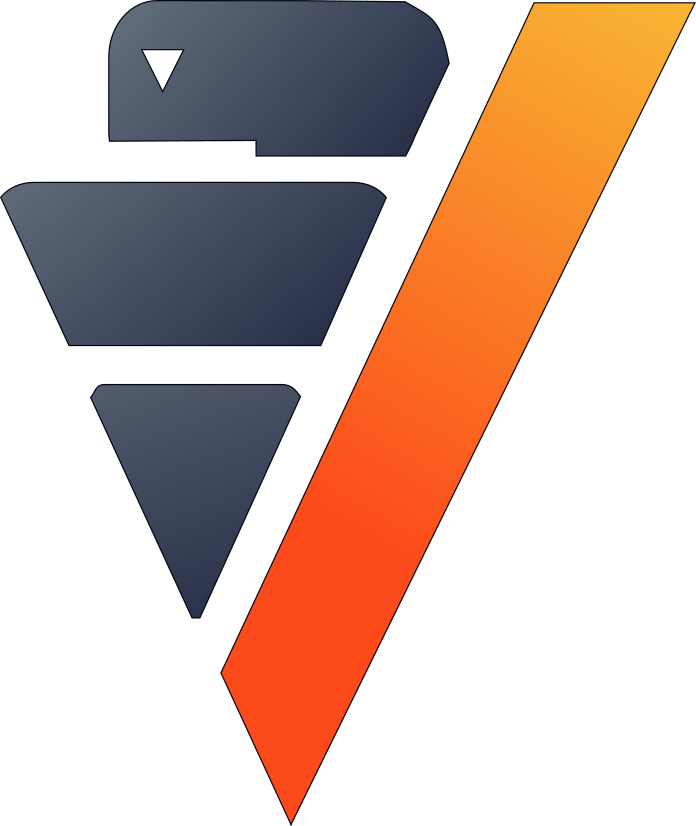

In [29]:
from verticapy.learn.delphi import AutoML

model = AutoML("battery_data.battery_autoML", 
               estimator = "native")
model.fit("battery_data.finaldata_battery_5", 
          X = ["min_temp",
               "max_temp",
               "min_volt",
               "time_to_reach_minvolt",
               "time_to_reach_maxtemp"],
          y = "SOH")

We can visualize the performance and efficency differences of each model with a plot.

<AxesSubplot:xlabel='time', ylabel='score'>

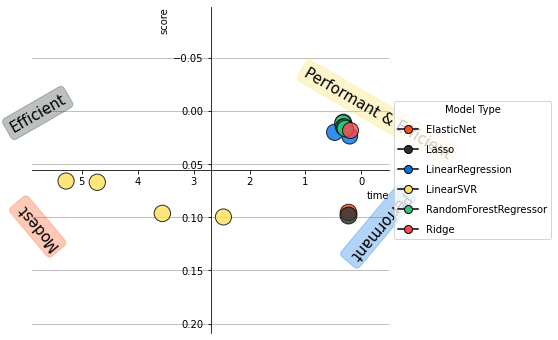

In [30]:
model.plot()

Let's check the type and hyperparameters of the most performant model.

In [31]:
# take the best model and its parameters
best_model = model.best_model_
params = best_model.get_params()
print(best_model.type)

RandomForestRegressor


We can now define the model using those hyperparameters and train it.

value  
explained_variance              0.997659518246552  
max_error                      0.0375041491629448  
median_absolute_error         0.00184377468342722  
mean_absolute_error           0.00278192359172081  
mean_squared_error           2.11456072683787e-05  
root_mean_squared_error      0.004598435306534028  
r2                              0.997653174398044  
r2_adj                         0.9975807415090947  
aic                           -1795.8434267288283  
bic                           -1777.6213819828436  
Rows: 1-10 | Columns: 2
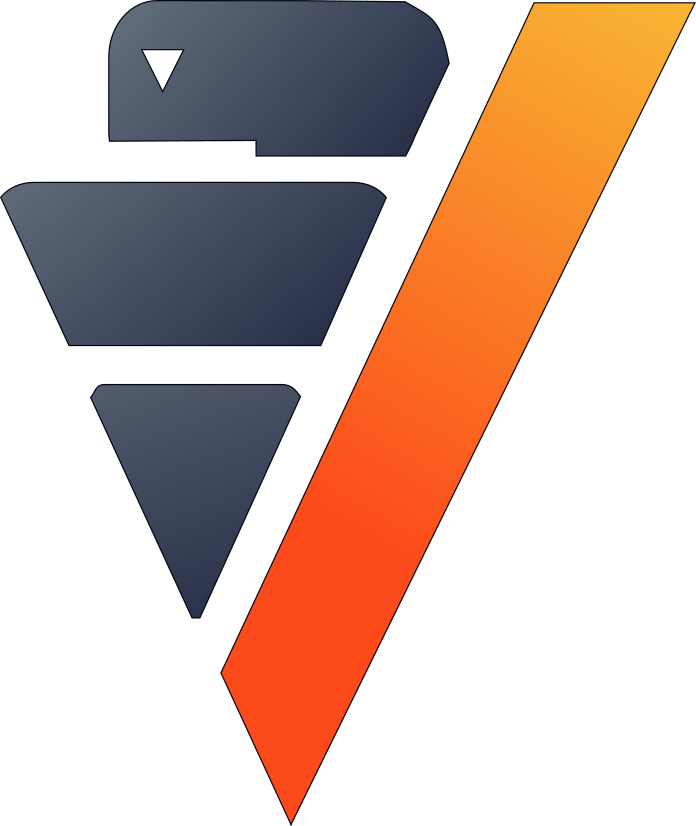

In [32]:
from verticapy.learn.ensemble import RandomForestRegressor

# define a regression model based on the selected parameters
model_rf = RandomForestRegressor(name = "btr_rf1", **params)
model_rf.fit(final_df,
             X = ["min_temp",
                  "max_temp",
                  "min_volt",
                  "time_to_reach_minvolt",
                  "time_to_reach_maxtemp"],
             y = "SOH")
model_rf.regression_report()

The predictive power of our model looks pretty good. Let's use our model to predict the SoH of the battery. We can visualize our prediction with a plot against the true values.

<AxesSubplot:xlabel='"start_time"'>

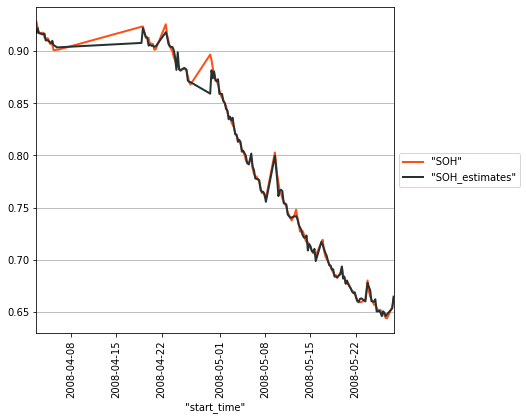

In [33]:
# take the predicted values and the plot them along the true ones
result = model_rf.predict(final_df, 
                          name = "SOH_estimates")
result.plot(ts = 'start_time', 
            columns = ['SOH', 'SOH_estimates'])

### Conclusion

We successfully defined a battery degradation model that can make accurate predictions about the health of a Li-ion battery. This model could be used to, for example, accurately send warnings to users when their batteries meet the EOL criteria.